In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)


py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os,random, math, psutil, pickle
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
import os
print(os.listdir("./"))

['train.csv', 'Untitled2.ipynb', 'cat_feature_index.a505f1c3-992000a-581507a7-309280cc.tmp', 'sample_submission.csv', 'sample_submission.csv.zip', 'building_metadata.csv', 'energy_sub.csv', 'weather_test.csv', 'weather_train.csv', '.ipynb_checkpoints', 'weather_train.csv.zip', 'train.csv.zip', 'test.csv', 'cat_feature_index.12d7a440-a0c2b8f3-6283ee1a-8628ec58.tmp', 'cat_feature_index.d6cd3695-b92f2d37-473f515b-71b3b946.tmp', 'test.csv.zip', 'catboost_info', 'Untitled1.ipynb', 'cat_feature_index.b25268d2-cc63a851-8f034f1-2cadb8eb.tmp', 'weather_test.csv.zip', 'Untitled.ipynb']


In [3]:
root = "./"
train = pd.read_csv(root + 'train.csv')
# train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train = pd.read_csv(root + 'weather_train.csv')
test = pd.read_csv(root + 'test.csv')
weather_test = pd.read_csv(root + 'weather_test.csv')
building_meta = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

In [4]:
train = train.merge(building_meta, on='building_id', how='left')
test = test.merge(building_meta, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [5]:
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}

for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    test[feature] = test[feature].astype(d_types[feature])
    
train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])
gc.collect();

In [6]:
dataset = train
train.head(5)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0


In [37]:
from sklearn.preprocessing import LabelEncoder

print(train.isnull().sum())
data_ratios = train.count()/len(train)
print("\n")
print(data_ratios)

class ASHRAE3Preprocessor(object):
    @classmethod
    def fit(cls, df, data_ratios=data_ratios):
        #对缺失值进行补充
        cls.avgs = df.loc[:,data_ratios < 1.0].mean()
        cls.pu_le = LabelEncoder()
        cls.pu_le.fit(df["primary_use"])

    @classmethod
    def transform(cls, df):
        #time_stamp和primary_use为非数值形式，要将其转换为数值形式
        df = df.fillna(cls.avgs) # refill NAN with averages
        df['primary_use'] = np.uint8(cls.pu_le.transform(df['primary_use']))  # encode labels

        # expand datetime into its components
#         df['hour'] = np.uint8(df['timestamp'].dt.hour)
#         df['day'] = np.uint8(df['timestamp'].dt.day)
#         df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
#         df['month'] = np.uint8(df['timestamp'].dt.month)
#         df['year'] = np.uint8(df['timestamp'].dt.year-2000)
        
        # parse and cast columns to a smaller type
        df.rename(columns={"square_feet": "log_square_feet"}, inplace=True)
        #加个log
        df['log_square_feet'] = np.float16(np.log(df['log_square_feet']))
        df['year_built'] = np.uint8(df['year_built']-1900)
        df['floor_count'] = np.uint8(df['floor_count'])
        
        # remove redundant columns
#         for col in df.columns:
#             if col in ['timestamp', 'row_id']:
#                 del df[col]
    
        # extract target column
        if 'meter_reading' in df.columns:
            df['meter_reading'] = np.log1p(df['meter_reading']).astype(np.float32) # comp metric uses log errors

        return df
        
ASHRAE3Preprocessor.fit(train)

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64


building_id           1.000000
meter                 1.000000
timestamp             1.000000
meter_reading         1.000000
site_id               1.000000
primary_use           1.000000
square_feet           1.000000
year_built            0.400100
floor_count           0.173472
air_temperature       0.995219
cloud_coverage        0.563449
dew_temperature       0.995047
precip_depth_1_hr     0.814553
sea_level_pressure    0.939075
wind_direction        0.928322
wind_speed            0.

In [38]:
train = ASHRAE3Preprocessor.transform(train)
train.head(5)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,log_square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,0,8.914062,108,4,25.0,6.0,20.0,0.796387,1019.700012,0.0,0.0
1,1,0,2016-01-01,0.0,0,0,7.910156,104,4,25.0,6.0,20.0,0.796387,1019.700012,0.0,0.0
2,2,0,2016-01-01,0.0,0,0,8.585938,91,4,25.0,6.0,20.0,0.796387,1019.700012,0.0,0.0
3,3,0,2016-01-01,0.0,0,0,10.070312,102,4,25.0,6.0,20.0,0.796387,1019.700012,0.0,0.0
4,4,0,2016-01-01,0.0,0,0,11.664062,75,4,25.0,6.0,20.0,0.796387,1019.700012,0.0,0.0


In [7]:
dataset["meter_reading"].value_counts()

0.0000       1873976
20.0000        23363
2.9307         23181
36.6000        22154
8.7921         21787
24.4000        21612
5.8614         21309
30.0000        20853
61.0000        20826
10.0000        20712
33.5500        20019
25.0000        19339
4.0000         19184
24.0000        18871
21.3500        18777
27.4500        18748
18.0000        17614
30.5000        16955
100.0000       16460
6.0000         16429
31.0000        15878
27.0000        15630
26.0000        15598
21.0000        15543
36.0000        15509
39.6500        15375
28.0000        15353
2.0000         15348
11.7228        15136
29.0000        14990
              ...   
3003.8000          1
2976.9500          1
57.2411            1
436.1820           1
24.4296            1
91.6348            1
28.2318            1
60.0158            1
435.1930           1
436.8070           1
72.7086            1
13.6949            1
13.6801            1
73.1845            1
2995.0500          1
31.0494            1
91.5723      

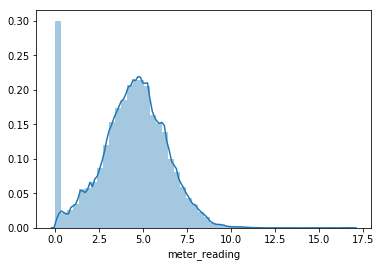

In [8]:
g = sns.distplot(np.log1p(dataset["meter_reading"]))

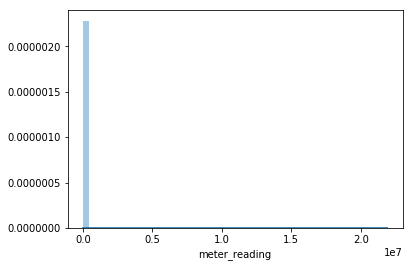

In [45]:
g = sns.distplot(dataset["meter_reading"])

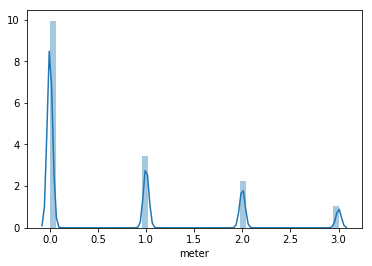

In [12]:
g = sns.distplot(dataset["meter"])

In [9]:
dataset["timestamp"] = pd.to_datetime(dataset["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [10]:
test["timestamp"] = pd.to_datetime(test["timestamp"], format='%Y-%m-%d %H:%M:%S')

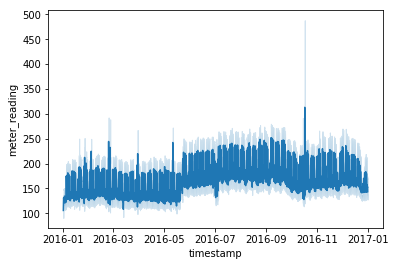

In [11]:
sns.lineplot(x='timestamp',y='meter_reading',data=dataset[dataset["meter"] == 0])

In [12]:
df_one_building = dataset[dataset.building_id == 1258]

In [14]:
df_one_building.head(10)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1881,1258,0,2016-01-01 00:00:00,910.464,14,Education,273234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1882,1258,1,2016-01-01 00:00:00,2509.150,14,Education,273234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1883,1258,2,2016-01-01 00:00:00,2923.120,14,Education,273234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1884,1258,3,2016-01-01 00:00:00,891.480,14,Education,273234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4177,1258,0,2016-01-01 01:00:00,916.448,14,Education,273234,NaN,NaN,5.6,0.0,-0.6,0.0,1019.299988,300.0,2.6
4178,1258,1,2016-01-01 01:00:00,1957.440,14,Education,273234,NaN,NaN,5.6,0.0,-0.6,0.0,1019.299988,300.0,2.6
4179,1258,2,2016-01-01 01:00:00,13590.600,14,Education,273234,NaN,NaN,5.6,0.0,-0.6,0.0,1019.299988,300.0,2.6
6473,1258,0,2016-01-01 02:00:00,934.457,14,Education,273234,NaN,NaN,5.6,4.0,-0.6,0.0,1019.400024,300.0,2.6
6474,1258,1,2016-01-01 02:00:00,2000.400,14,Education,273234,NaN,NaN,5.6,4.0,-0.6,0.0,1019.400024,300.0,2.6
6475,1258,2,2016-01-01 02:00:00,3079.990,14,Education,273234,NaN,NaN,5.6,4.0,-0.6,0.0,1019.400024,300.0,2.6


/home/lwlw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



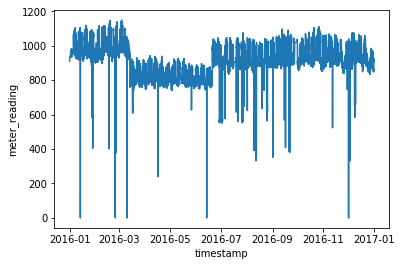

In [15]:
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[dataset["meter"] == 0])

/home/lwlw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



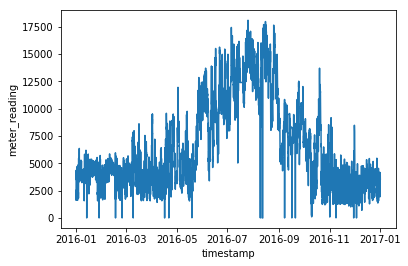

In [16]:
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[dataset["meter"] == 1])

/home/lwlw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



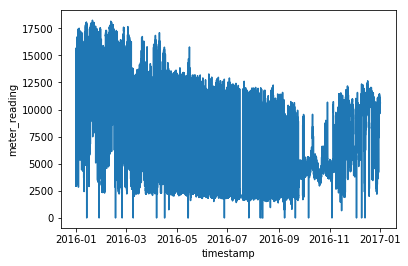

In [20]:
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[dataset["meter"] == 2])

/home/lwlw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



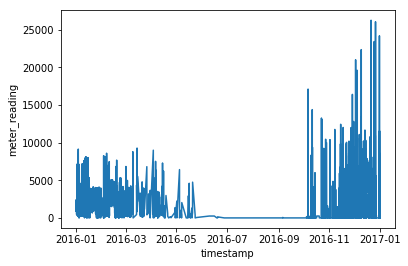

In [21]:
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[dataset["meter"] == 3])

In [22]:
df_one_building_test = test[test.building_id == 1258]

In [24]:
df_one_building_test.head(10)

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
32153817,32153817,1258,0,2017-01-01 01:00:00,14,Education,273234,NaN,NaN,5.6,NaN,-5.6,0.0,1013.099976,230.0,4.1
32153818,32153818,1258,1,2017-01-01 01:00:00,14,Education,273234,NaN,NaN,5.6,NaN,-5.6,0.0,1013.099976,230.0,4.1
32153819,32153819,1258,2,2017-01-01 01:00:00,14,Education,273234,NaN,NaN,5.6,NaN,-5.6,0.0,1013.099976,230.0,4.1
32153820,32153820,1258,3,2017-01-01 01:00:00,14,Education,273234,NaN,NaN,5.6,NaN,-5.6,0.0,1013.099976,230.0,4.1
32154105,32154105,1258,0,2017-01-01 02:00:00,14,Education,273234,NaN,NaN,5.6,NaN,-5.0,0.0,1012.299988,220.0,5.7
32154106,32154106,1258,1,2017-01-01 02:00:00,14,Education,273234,NaN,NaN,5.6,NaN,-5.0,0.0,1012.299988,220.0,5.7
32154107,32154107,1258,2,2017-01-01 02:00:00,14,Education,273234,NaN,NaN,5.6,NaN,-5.0,0.0,1012.299988,220.0,5.7
32154108,32154108,1258,3,2017-01-01 02:00:00,14,Education,273234,NaN,NaN,5.6,NaN,-5.0,0.0,1012.299988,220.0,5.7
32154393,32154393,1258,0,2017-01-01 03:00:00,14,Education,273234,NaN,NaN,5.6,NaN,-3.9,0.0,1011.900024,210.0,4.6
32154394,32154394,1258,1,2017-01-01 03:00:00,14,Education,273234,NaN,NaN,5.6,NaN,-3.9,0.0,1011.900024,210.0,4.6


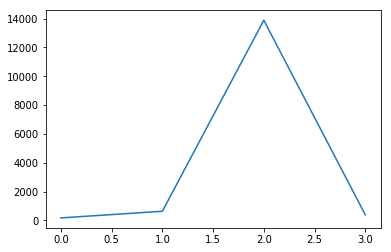

In [25]:
ave = []
for i in range(4):
    ave.append(dataset[(dataset.meter==i)].meter_reading.mean())
plt.plot(ave)

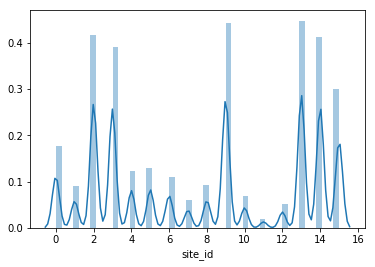

In [31]:
g = sns.distplot(dataset["site_id"])

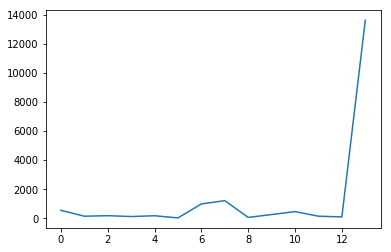

In [27]:
ave = []
for i in range(14):
    ave.append(dataset.loc[(dataset.site_id==i)].meter_reading.mean())
plt.plot(ave)

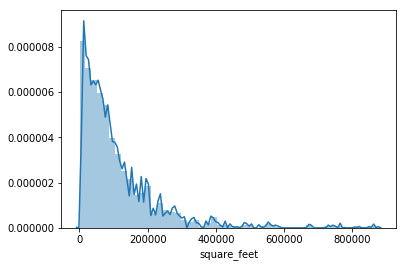

In [29]:
# dataset["square_feet"].value_counts()
g = sns.distplot(dataset["square_feet"])

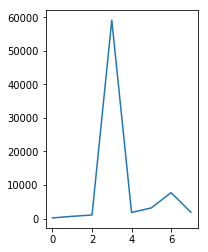

In [30]:
ave = []
for i in range(8):
    ave.append(dataset.loc[(dataset.square_feet/100000<i+1) & (dataset.square_feet/100000>=i)].meter_reading.mean())
plt.subplot(1,2,2)
plt.plot(ave)

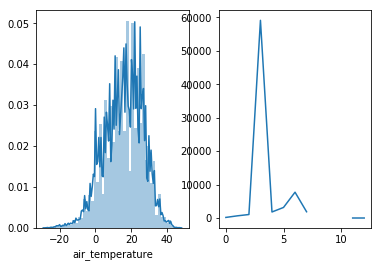

In [40]:
plt.subplot(1,2,1)
g = sns.distplot(train["air_temperature"].astype('int'))
for i in range(10):
    ave.append(train.loc[(dataset[feature]>-30+i*10) & (train[feature]<-20+i*10)].meter_reading.mean())
plt.subplot(1,2,2)
plt.plot(ave)

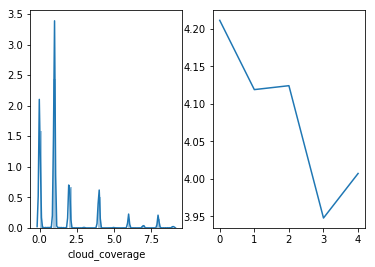

In [41]:
plt.subplot(1,2,1)
g = sns.distplot(train["cloud_coverage"].astype('int'))
ave = []
for i in [0,2,4,6,8]:
    ave.append(train.loc[(train["cloud_coverage"]==i)].meter_reading.mean())
plt.subplot(1,2,2)
plt.plot(ave)

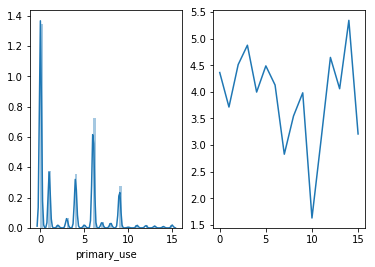

In [43]:
plt.subplot(1,2,1)
g = sns.distplot(train["primary_use"])
ave = []
for i in range(16):
    ave.append(train.loc[(train["primary_use"]==i)].meter_reading.mean())
plt.subplot(1,2,2)
plt.plot(ave)

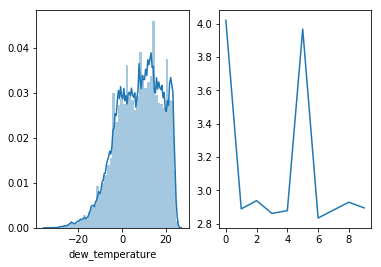

In [44]:
plt.subplot(1,2,1)
g = sns.distplot(train["dew_temperature"])
ave = []
for i in range(10):
    ave.append(train.loc[(train["dew_temperature"]==i)].meter_reading.mean())
plt.subplot(1,2,2)
plt.plot(ave)